In [4]:
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf
!pip install hmmlearn
from hmmlearn import hmm
import scipy
!pip install seaborn
import seaborn as sb
!pip install PyPortfolioOpt
from math import ceil
import matplotlib.pyplot as plt

     |████████████████████████████████| 283 kB 7.1 MB/s eta 0:00:01


In [6]:
tickers = ['FB','TSLA', 'XOM', 'WM', 'KR', 'GS', 'DISCK', 'STLD', 'JNJ', 'IBM', 'PCG', 'CBRE']
stonks = {} 

for ticker in tickers:
  stonks[ticker] = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
import datetime

min_dates = [stonks[ticker].index.min() for ticker in stonks]
start_date = max(min_dates).date()
start_date = pd.to_datetime(start_date)
print('start_date is:', start_date)


max_dates = [stonks[ticker].index.max() for ticker in stonks]
end_date = min(max_dates).date()
end_date = pd.to_datetime(end_date)
print('end_date is:', end_date)


for stonk in stonks:
  stonks[stonk] = stonks[stonk].loc[(stonks[stonk].index > start_date) & (stonks[stonk].index < end_date)]

start_date is: 2012-05-18 00:00:00
end_date is: 2020-12-03 00:00:00


In [10]:
stonk_arr = np.vstack([np.divide(stonks[stonk]['Adj Close'], stonks[stonk]['Adj Close'].shift(1)).to_numpy() for stonk in stonks]).T[1:]

#for stonk in stonks:
#  stonks[stonk]['log_ret'] = -(np.log(stonks[stonk]['Adj Close']) - np.log(stonks[stonk]['Adj Close'].shift(1)))
#Do we need to trim the last one off? - Brandon
#for stonk in stonks:
#  stonks[stonk] = stonks[stonk]['log_ret']

stonk_logret_arr = np.log(stonk_arr)

In [11]:
def mwu_strategy(stonk_arr, epsilon, gamma2=0.00):
  """
  stonks_arr: must be a numpy array of shape (number of ticks, Number of Stocks) with % changes from tick to tick
  gamma: The transaction cost as portion of the trade
  nu: parameter which determines the aggressiveness of changes in portfolio
  --------
  returns:
  p_arr: array of portfolio distributions
  portfolios: array of portfolio values
  """
  T, N = stonk_arr.shape
  pt = np.ones(N) / N
  f = np.log(np.ones(N) - epsilon)
  p_arr = [pt]
  portfolios = [1]
  for t in range(T):
    xt = stonk_arr[t]
    pt1 = pt * np.exp(f * -np.log(xt))
    pt1 = pt1 / np.sum(pt1)
    portfolios.append(portfolios[-1] * (np.dot(pt, xt) - gamma2*np.linalg.norm(pt1-pt, ord=1)))
    pt = pt1
    p_arr.append(pt)
  return np.array(p_arr), np.array(portfolios)

We based this on the paper "Online Lazy Updates for Portfolio Selection with Transaction Costs"
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.353.1269&rep=rep1&type=pdf

In [12]:
def lazy_strategy(stonk_arr, gamma=0.01, gamma2=0.00, nu=10):
  """
  stonks_arr: must be a numpy array of shape (number of ticks, Number of Stocks) with % changes from tick to tick
  gamma: The transaction cost as portion of the trade
  nu: parameter which determines the aggressiveness of changes in portfolio
  --------
  returns:
  p_arr: array of portfolio distributions
  portfolios: array of portfolio values
  """
  alpha = nu * gamma
  T, N = stonk_arr.shape
  pt = np.ones(N) / N
  p_arr = [pt]
  portfolios = [1]
  for t in range(T):
    xt = stonk_arr[t]
    constraint = scipy.optimize.LinearConstraint(np.ones(N), 1, 1)
    def obj(p):
      return -nu*np.log(np.dot(p, xt)) + alpha*np.linalg.norm(p - pt, ord=1) + 0.5*np.linalg.norm(p - pt, ord=2) #
    opt_result = scipy.optimize.minimize(obj, pt, bounds=[(0,1) for _ in range(N)], constraints= constraint)
    pt1 = opt_result.x
    portfolios.append(portfolios[-1] * (np.dot(pt, xt) - gamma2*np.linalg.norm(pt1-pt, ord=1)))
    pt = pt1
    p_arr.append(pt)
  return np.array(p_arr), np.array(portfolios)

In [13]:
def lazy_mwu_strategy(stonks_arr, gamma=0.01, gamma2=0.00, nu=10, epsilon=0.2):
  """
  stonks_arr: must be a numpy array of shape (number of ticks, Number of Stocks) with % changes from tick to tick
  gamma: The transaction cost as portion of the trade
  nu: parameter which determines the aggressiveness of changes in portfolio
  epsilon: speed up updates, much like in MWU
  --------
  returns:
  p_arr: array of portfolio distributions
  portfolios: array of portfolio values
  """
  alpha = nu * gamma
  T, N = stonk_arr.shape
  pt = np.ones(N) / N
  p_arr = [pt]
  portfolios = [1]
  for t in range(T):
    xt = stonk_arr[t]
    constraint = scipy.optimize.LinearConstraint(np.ones(N), 1, 1)
    def obj(p):
      return -nu*np.log(np.dot(p, xt)) + alpha*np.linalg.norm(p - pt, ord=1) #+ 0.5*np.linalg.norm(p - pt, ord=2) #
    opt_result = scipy.optimize.minimize(obj, pt, bounds=[(0,1) for _ in range(N)], constraints= constraint)
    pt1 = epsilon*(opt_result.x - pt) + pt
    portfolios.append(portfolios[-1] * (np.dot(pt, xt) - gamma2*np.linalg.norm(pt1-pt, ord=1)))
    pt = pt1
    p_arr.append(pt)
  return np.array(p_arr), np.array(portfolios)

Took inspiration from the federal reserve working paper: "Asset Allocation under Multivariate Regime Switching". They use a similar HMM to predict regime switches and they use four states: "crash, slow growth, bull and recovery". Our HMM with 4 states predicts similar results and I use the variances of the observations as a proxy for volatility which lets the strategy avoid risk due to its trend following nature.

Link: https://files.stlouisfed.org/files/htdocs/wp/2005/2005-002.pdf

In [14]:
def hmm_strategy(stonk_arr, model, gamma=0.01, gamma2=0.00, nu=10, epsilon=0.2, retrain=100):
  """
  stonks_arr: must be a numpy array of shape (number of ticks, Number of Stocks) with % changes from tick to tick
  model: A hidden markov model which can be used to predict regimes
  gamma: The transaction cost as portion of the trade
  nu: parameter which determines the aggressiveness of changes in portfolio
  epsilon: speed up updates, much like in MWU
  --------
  returns:
  p_arr: array of portfolio distributions
  portfolios: array of portfolio values
  """
  EPSILON = epsilon
  alpha = nu * gamma
  T, N = stonk_arr.shape
  pt = np.ones(N) / N
  p_arr = [pt]
  portfolios = [1]
  eras = ceil(T / retrain)
  volatile_state = np.argmax(model.covars_)
  for era in range(eras):
    if era != 0:
      model.fit(stonk_arr[0:era*retrain].ravel().reshape(-1, 1), [era*retrain for s in range(N)])
      volatile_state = np.argmax(model.covars_)
    for t in range(era*retrain, min((era+1)*retrain, T)):
      state = model.decode(stonk_arr[0:t+1].ravel().reshape(-1, 1), [t+1 for s in range(N)])[1][-1]
      if state == volatile_state:
        epsilon = EPSILON / 2
      else:
        epsilon = EPSILON
      xt = stonk_arr[t]
      constraint = scipy.optimize.LinearConstraint(np.ones(N), 1, 1)
      def obj(p):
        return -nu*np.log(np.dot(p, xt)) + alpha*np.linalg.norm(p - pt, ord=1) #+ 0.5*np.linalg.norm(p - pt, ord=2) #
      opt_result = scipy.optimize.minimize(obj, pt, bounds=[(0,1) for _ in range(N)], constraints= constraint)
      pt1 = epsilon*(opt_result.x - pt) + pt
      portfolios.append(portfolios[-1] * (np.dot(pt, xt) - gamma2*np.linalg.norm(pt1-pt, ord=1)))
      pt = pt1
      p_arr.append(pt)
  return np.array(p_arr), np.array(portfolios)

In [15]:
p_arr_mwu, portfolios_mwu = mwu_strategy(stonk_arr, 0.3)
p_arr_lazy, portfolios_lazy = lazy_strategy(stonk_arr)
p_arr_lazy_mwu, portfolios_lazy_mwu = lazy_mwu_strategy(stonk_arr)
model = hmm.GaussianHMM(n_components=4, covariance_type="full", tol=1e-2, algorithm='map')
n_train = 200
stonk_train_arr = stonk_arr[:n_train]
stonk_test_arr = stonk_arr[n_train:]
model.fit(stonk_train_arr.ravel().reshape(-1, 1), [n_train for s in range(stonk_arr.shape[1])])
model.init_params = ''
print(stonk_arr.shape)
print(stonk_test_arr.shape)
p_arr_hmm, portfolios_hmm = hmm_strategy(stonk_arr=stonk_test_arr, model=model, retrain=n_train)

(2148, 12)
(1948, 12)


Text(0, 0.5, 'value of HMM-augmented portfolio')

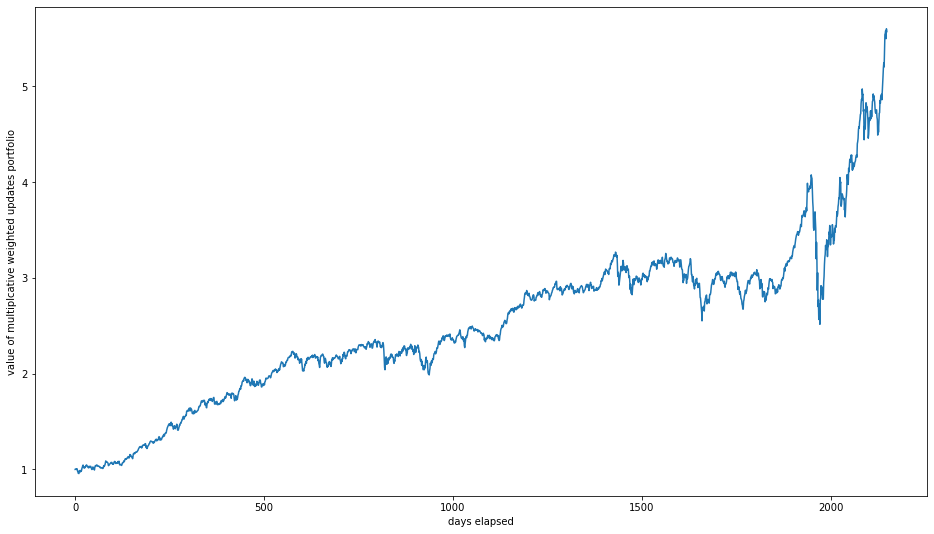

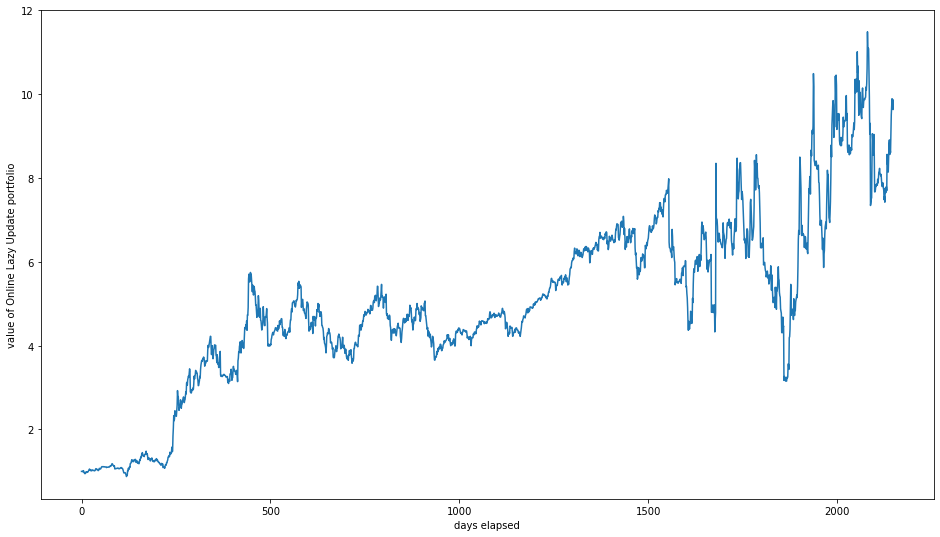

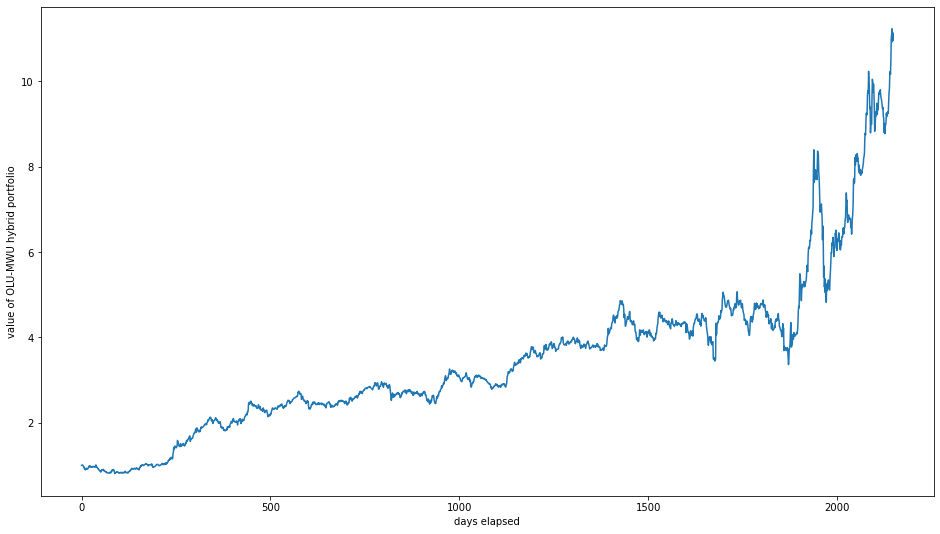

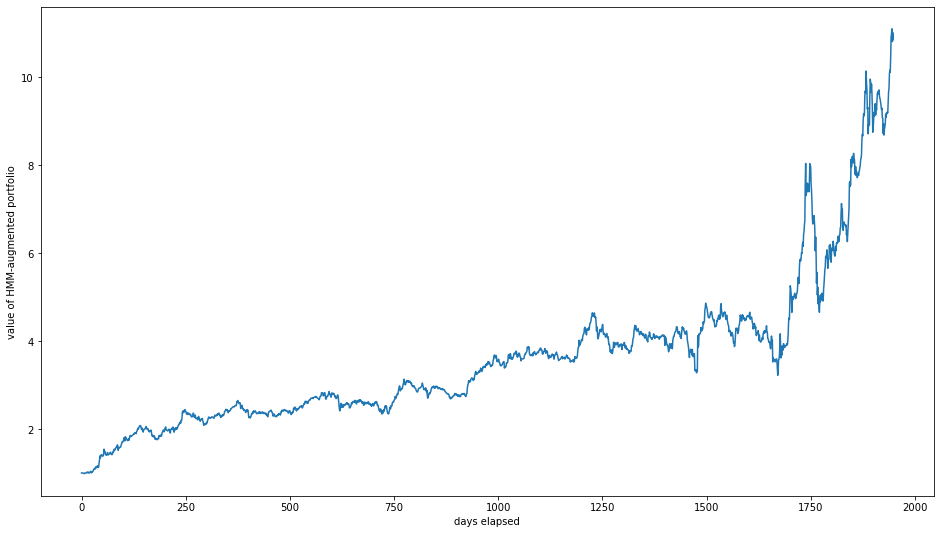

In [17]:
fig, ax1 = plt.subplots(figsize=(16,9))
sb.lineplot(data=portfolios_mwu, ax=ax1)
ax1.set_xlabel('days elapsed')
ax1.set_ylabel('value of multiplcative weighted updates portfolio')

fig, ax2 = plt.subplots(figsize=(16,9))
sb.lineplot(data=portfolios_lazy, ax=ax2)
ax2.set_xlabel('days elapsed')
ax2.set_ylabel('value of Online Lazy Update portfolio')

fig, ax3 = plt.subplots(figsize=(16,9))
sb.lineplot(data=portfolios_lazy_mwu, ax=ax3)
ax3.set_xlabel('days elapsed')
ax3.set_ylabel('value of OLU-MWU hybrid portfolio')

fig, ax4 = plt.subplots(figsize=(16,9))
sb.lineplot(data=portfolios_hmm, ax=ax4)
ax4.set_xlabel('days elapsed')
ax4.set_ylabel('value of HMM-augmented portfolio')

In [18]:
p_arr_mwu2, portfolios_mwu2 = mwu_strategy(stonk_arr, 0.3, gamma2=0.01)
p_arr_lazy2, portfolios_lazy2 = lazy_strategy(stonk_arr, gamma2=0.01)

Text(0, 0.5, 'value of Online Lazy Update portfolio')

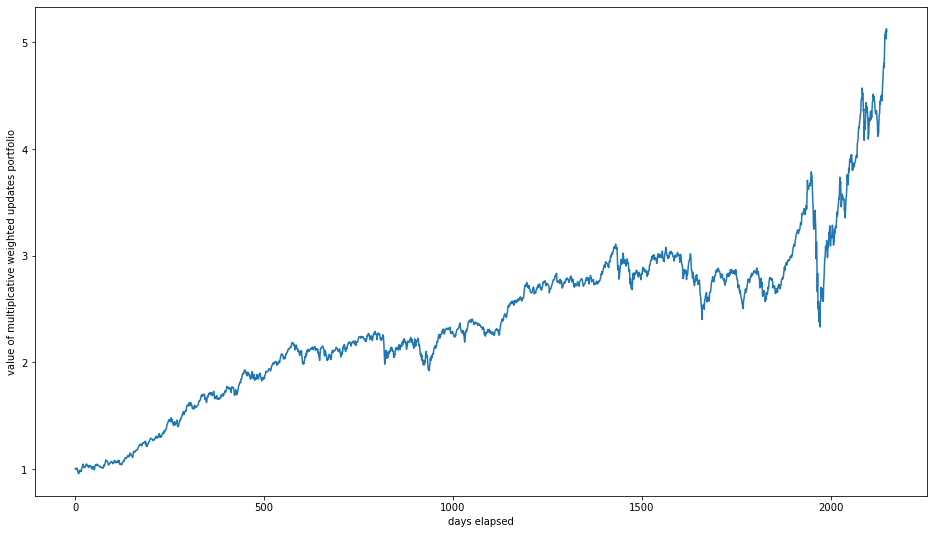

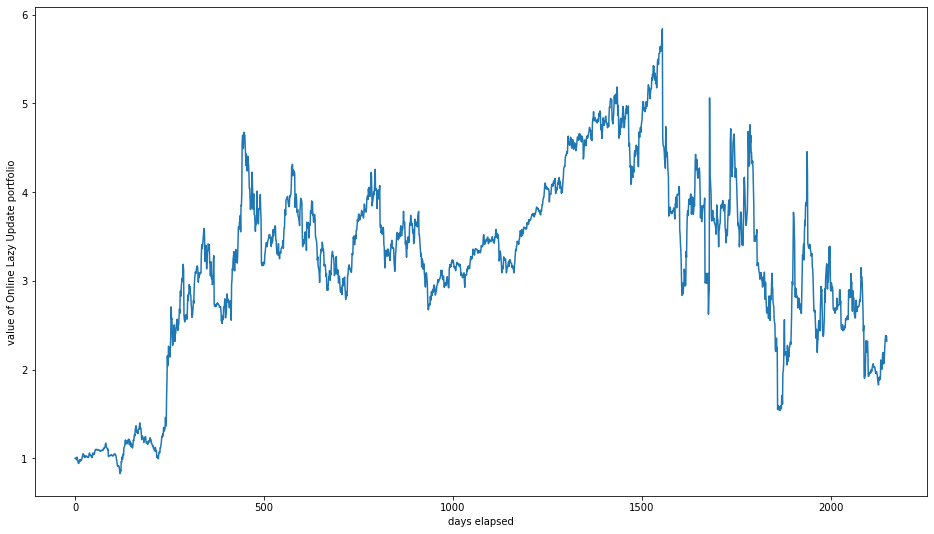

In [20]:
fig, ax5 = plt.subplots(figsize=(16,9))
sb.lineplot(data=portfolios_mwu2, ax=ax5)
ax5.set_xlabel('days elapsed')
ax5.set_ylabel('value of multiplcative weighted updates portfolio')

fig, ax6 = plt.subplots(figsize=(16,9))
sb.lineplot(data=portfolios_lazy2, ax=ax6)
ax6.set_xlabel('days elapsed')
ax6.set_ylabel('value of Online Lazy Update portfolio')

Text(0, 0.5, 'Weight on FB with Lazy Strategy')

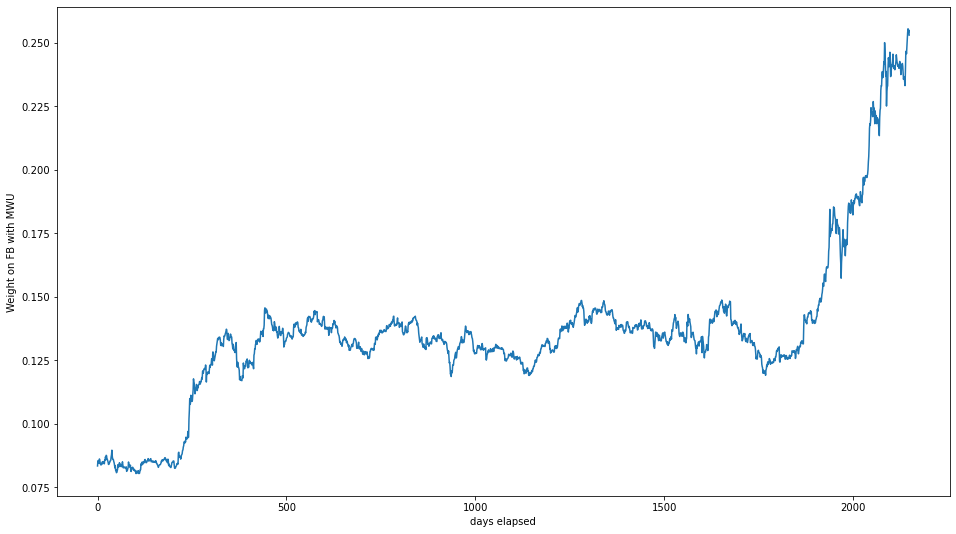

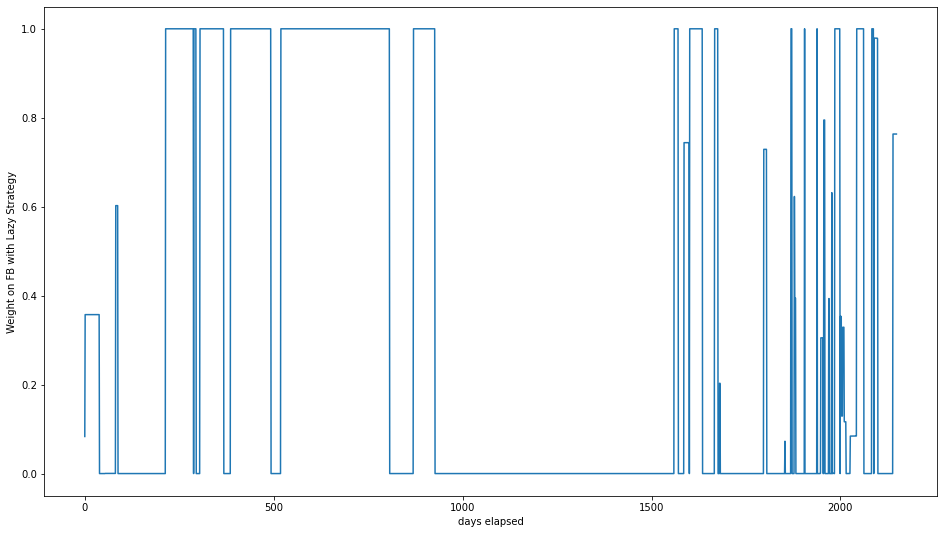

In [29]:
fig, ax7 = plt.subplots(figsize=(16,9))
sb.lineplot(data=p_arr_mwu[:,1], ax=ax7)
ax7.set_xlabel('days elapsed')
ax7.set_ylabel('Weight on FB with MWU')

fig, ax8 = plt.subplots(figsize=(16,9))
sb.lineplot(data=p_arr_lazy[:,1], ax=ax8)
ax8.set_xlabel('days elapsed')
ax8.set_ylabel('Weight on FB with Lazy Strategy')

The code in the next cell implements a mean-variance portfolio strategy with the same tickers as before. We use the first 100 days to come up with a sample covariance matrix and expected returns, and then use a library to maximize the Sharpe ratio of the portfolio. The interesting part is that the model imposes a constraint of 1% transaction costs, i.e. every change in weight occurs a 1% fee, which is a bit high. Our model made decisions in accordance with this but we couldn't directly calculate the changes in portfolio value due to transaction fees (it was decreasing too quickly). So that's something to explore for later.

Links:
https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/3-Advanced-Mean-Variance-Optimisation.ipynb
https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html

In [39]:
import pypfopt
from pypfopt import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import DiscreteAllocation
from pypfopt import risk_models

tickers = ['FB','TSLA', 'XOM', 'WM', 'KR', 'GS', 'DISCK', 'STLD', 'JNJ', 'IBM', 'PCG', 'CBRE']
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices = prices.loc[(prices.index > start_date) & (prices.index < end_date)]


initial_weights = np.array([1/len(tickers) for _ in range(len(tickers))])
weights = initial_weights
T, N = prices.shape
print(T)


price_array = prices[3:100]
avg_returns = expected_returns.mean_historical_return(price_array)
S = risk_models.CovarianceShrinkage(price_array).ledoit_wolf()
ef = EfficientFrontier(avg_returns, S)
ef.add_objective(objective_functions.transaction_cost, w_prev=np.array(initial_weights), k=0.01)
ef.max_sharpe()
weights = ef.clean_weights()
weights = [weights[x] for x in weights]
print(weights)
portfolio_value = []
weight_of_one_stock = []
weight_of_another_stock = []

for t in range(101, T):
  price_array = prices[3:t]
  avg_returns = expected_returns.mean_historical_return(price_array)
  S = risk_models.CovarianceShrinkage(price_array).ledoit_wolf()
  ef = EfficientFrontier(avg_returns, S)
  ef.add_objective(objective_functions.transaction_cost, w_prev=np.array(weights), k=0.01)
  ef.max_sharpe()
  old_weights = weights
  weights = ef.clean_weights()
  weights = [weights[x] for x in weights]
  xt = np.dot(np.array(weights), (prices.to_numpy())[t])
  portfolio_value.append(xt)
  weight_of_one_stock.append(weights[0])
  weight_of_another_stock.append(weights[1])

[*********************100%***********************]  12 of 12 completed
2149
[0.0, 0.36386, 0.0, 0.4253, 0.0, 0.15968, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05117]


/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."
/home/khoa/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe t

Text(0, 0.5, 'weight of TSLA')

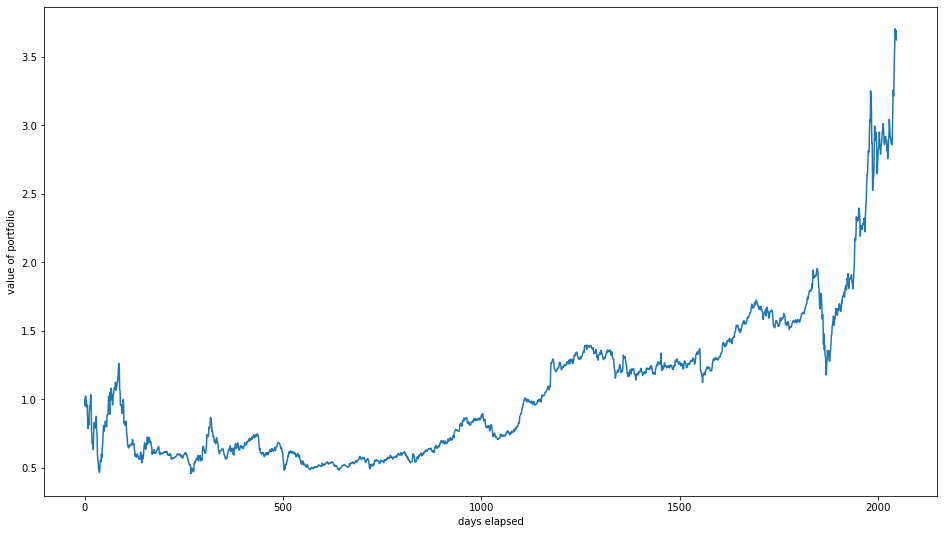

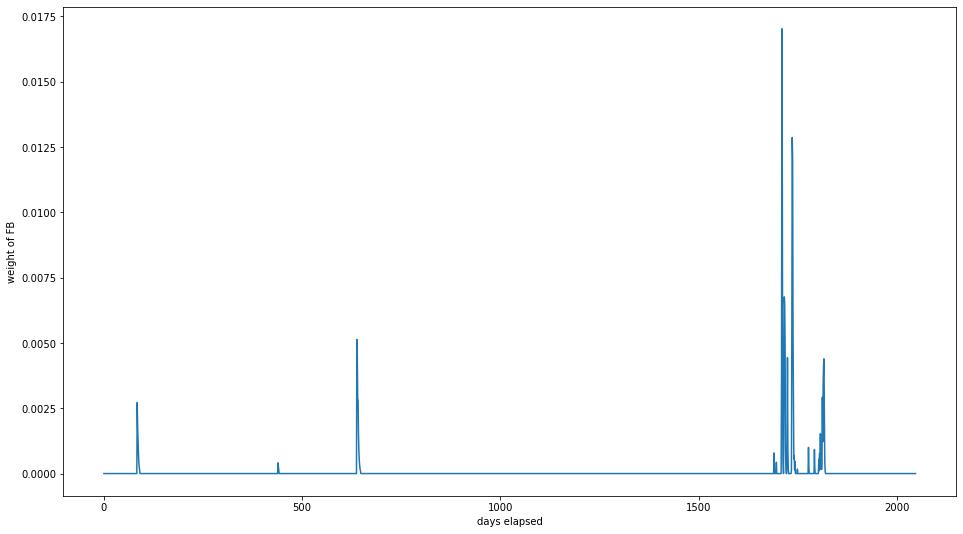

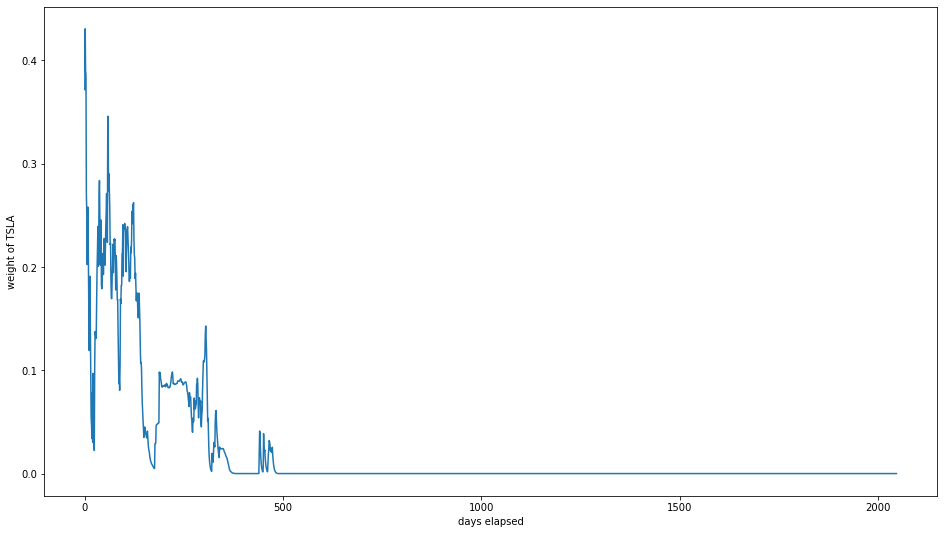

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
sb.lineplot(data=portfolio_value/portfolio_value[0], ax=ax)
ax.set_xlabel('days elapsed')
ax.set_ylabel('value of portfolio')

fig, ax = plt.subplots(figsize=(16,9))
sb.lineplot(data=weight_of_one_stock, ax=ax)
ax.set_xlabel('days elapsed')
ax.set_ylabel('weight of FB')

fig, ax = plt.subplots(figsize=(16,9))
sb.lineplot(data=weight_of_another_stock, ax=ax)
ax.set_xlabel('days elapsed')
ax.set_ylabel('weight of TSLA')